In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as stats

In [2]:
df = pd.read_csv('analytics_test.csv', index_col=0)

In [3]:
df.head()

,user_id,sex,age,platform,query_id,query_text,query_type,event,click_position,doc_type,view_time
0,96422511,female,68,android,89656828,передачи о новых технологиях,show,share,6,playlist,0
1,45247030,male,62,android_tv,89784877,автопрому новости,news,search,0,NaN,0
2,79572413,male,12,web,10555855,логистическое законодательство,news,search,0,NaN,0
3,821317,female,58,android_tv,72054848,банковские премии новости,news,search,0,NaN,0
4,6206023,female,24,android,20838049,вики шоу аманда,show,subscribe,7,author,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         20000 non-null  int64 
 1   sex             20000 non-null  object
 2   age             20000 non-null  int64 
 3   platform        20000 non-null  object
 4   query_id        20000 non-null  int64 
 5   query_text      20000 non-null  object
 6   query_type      20000 non-null  object
 7   event           20000 non-null  object
 8   click_position  20000 non-null  int64 
 9   doc_type        15042 non-null  object
 10  view_time       20000 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 1.8+ MB


In [5]:
df.describe()

,user_id,age,query_id,click_position,view_time
count,2.000000e+04,20000.000000,2.000000e+04,20000.000000,20000.000000
mean,4.940472e+07,30.029600,1.629075e+08,6.216150,614.775450
std,2.896590e+07,22.588294,2.443505e+08,6.389262,2217.290922
min,1.273000e+03,0.000000,8.758000e+03,0.000000,0.000000
25%,2.405560e+07,11.000000,3.215079e+07,0.000000,0.000000
50%,4.946180e+07,30.000000,6.425107e+07,4.000000,0.000000
75%,7.429182e+07,50.000000,9.664634e+07,10.000000,0.000000
max,9.999570e+07,69.000000,9.998612e+08,30.000000,17994.000000


## Гипотеза: Низкое качество при длинных или слишком коротких запросах
Если длина query_text слишком короткая или очень длинная пользователи реже совершают meaningful действия (like, subscribe, view) после поиска.

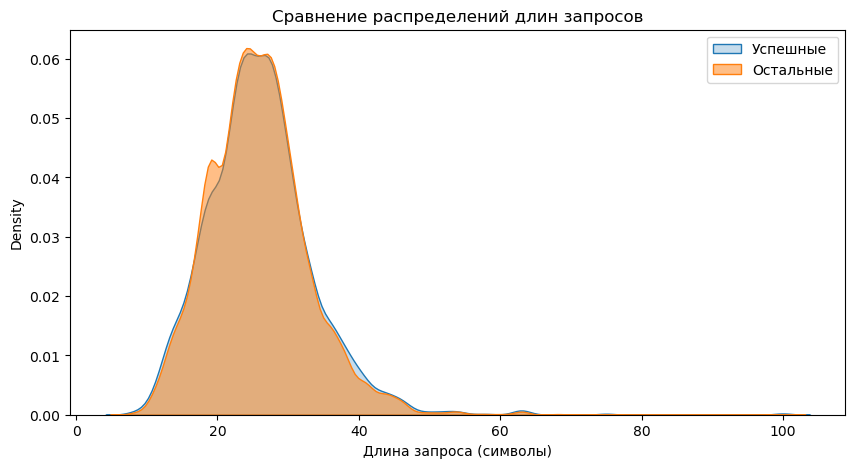

In [7]:
# Добавим флаг успешности
df['is_success'] = df['event'].isin(['view', 'like', 'subscribe'])

# Разделим данные
success_lengths = df[df['is_success']]['query_text'].str.len().dropna()
other_lengths = df[~df['is_success']]['query_text'].str.len().dropna()

# График
plt.figure(figsize=(10, 5))
sns.kdeplot(success_lengths, label='Успешные', fill=True)
sns.kdeplot(other_lengths, label='Остальные', fill=True, alpha=0.5)
plt.title('Сравнение распределений длин запросов')
plt.xlabel('Длина запроса (символы)')
plt.legend()
plt.show()

**Думаю, данную гипотезу можно отвергнуть, распределения почти не отличаются**

## Гипотеза: Проблемы с определением типа документа
Если после поиска (event = search) документ в результатах имеет неопределённый тип (doc_type = NaN), пользователи реже совершают целевые действия (tap, like, view, subscribe)"

In [10]:
# df['doc_type'].value_counts()

In [11]:
df['is_doc_ambiguous'] = df['doc_type'].isna().astype(int)

In [12]:
# Группируем по query_id и проверяем успешность
search_sessions = df[df['event'] == 'search'].groupby('query_id').agg(
    has_success_event=('event', lambda x: any(e in ['tap', 'like', 'view', 'subscribe'] for e in x)),
    is_doc_ambiguous=('is_doc_ambiguous', 'max')  # 1 если хотя бы один doc_type в сессии NaN
).reset_index()

In [13]:
failure_rates = search_sessions.groupby('is_doc_ambiguous')['has_success_event'].agg(
    success_rate='mean',
    count='count'
)
failure_rates['failure_rate'] = 1 - failure_rates['success_rate']
print(failure_rates)

                  success_rate  count  failure_rate
is_doc_ambiguous                                   
1                          0.0   4677           1.0


**Во всех 4677 случаях, когда тип документа (doc_type) был неопределён (is_doc_ambiguous = 1), пользователи никогда не совершали целевых действий (tap, like, view, subscribe) после поиска.**

In [15]:
top_failed_queries = df[df['doc_type'].isna()]['query_text'].value_counts().head(5)
print(top_failed_queries)

query_text
альтернативные концовки известных фильмов         25
самые низкооцененные фильмы на Rotten Tomatoes    23
фильмы про искусственный интеллект                23
фильмы, снятые в Париже                           23
русские фильмы про войну                          22
Name: count, dtype: int64


**При doc_type=NaN можно предлагать гибридную выдачу (например, видео + плейлисты + клипы).**

## Гипотеза: Высокая доля кликов на элементы внизу выдачи
Если клики (tap) чаще происходят на позициях > 4, а верх выдачи (позиции 1-4) игнорируется, значит, верх нерелевантен. \
Дополнительно: если клики внизу выдачи реже приводят к лайкам/подпискам/шэрам, это усиливает проблему.

Нужно учесть, что есть события поиска, когда click_position = 0 - их убираем из анализа

In [19]:
# 1. Фильтруем только реальные клики (исключаем search и другие события без позиции)
real_clicks = df[(df['event'] == 'tap') & (df['click_position'] > 0)].copy()

# 2. Разделяем на группы
real_clicks['position_group'] = np.where(real_clicks['click_position'] <= 4, 'top', 'bottom')

# 3. Распределение кликов по группам
clicks_distribution = real_clicks['position_group'].value_counts(normalize=True)
print("Корректное распределение кликов:\n", clicks_distribution)

Корректное распределение кликов:
 position_group
bottom    0.689515
top       0.310485
Name: proportion, dtype: float64


**Гипотеза подтверждается - верх выдачи нерелевантен, если судить по тапам \
Попробуем посмотреть не только на тапы, но и на другие события**

In [21]:
# 1. Фильтруем только реальные клики (исключаем search и другие события без позиции)
real_clicks = df[(df['click_position'] > 0)].copy()

# 2. Разделяем на группы
real_clicks['position_group'] = np.where(real_clicks['click_position'] <= 4, 'top', 'bottom')

# 3. Распределение кликов по группам
clicks_distribution = real_clicks['position_group'].value_counts(normalize=True)
print("Корректное распределение кликов:\n", clicks_distribution)

Корректное распределение кликов:
 position_group
bottom    0.675905
top       0.324095
Name: proportion, dtype: float64


**Гипотеза подтверждается - верх выдачи нерелевантен**

## Гипотеза: Проблемы на определённых платформах
На некоторых platform может быть статистически значима ниже вовлечённость

In [123]:
engaged_events = ['tap', 'view', 'like', 'subscribe', 'share']
df['is_engaged'] = df['event'].isin(engaged_events)
ctr_by_platform = df.groupby('platform')['is_engaged'].mean().sort_values()
print("Вовлечённость по платформам (CTR):\n", ctr_by_platform)

Вовлечённость по платформам (CTR):
 platform
android       0.749176
android_tv    0.749812
smart_tv      0.750411
web           0.754216
iphone        0.757189
Name: is_engaged, dtype: float64


In [133]:
contingency_table = pd.crosstab(df['platform'], df['is_engaged'])
print("Контингентная таблица (платформа × вовлечённость):")
contingency_table

Контингентная таблица (платформа × вовлечённость):


is_engaged,False,True
platform,,
android,1065,3181
android_tv,997,2988
iphone,1047,3265
smart_tv,1062,3193
web,787,2415


In [139]:
# Хи-квадрат тест
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"\nХи-квадрат статистика = {chi2:.4f}")
print(f"p-value = {p:.5f}")

if p < 0.05:
    print("Различия между платформами статистически значимы (отклоняем H0)")
else:
    print("Нет статистически значимых различий (не отклоняем H0)")


Хи-квадрат статистика = 1.0477
p-value = 0.90249
Нет статистически значимых различий (не отклоняем H0)


**CTR по платформам не отличается, изначальная гипотеза отвергается**

In [145]:
# Сравним TV и non-TV
from statsmodels.stats.proportion import proportions_ztest

df['platform_group'] = np.where(
    df['platform'].isin(['android_tv', 'smart_tv']),
    'tv',
    'non_tv'
)

agg = df.groupby('platform_group')['is_engaged'].agg(['sum', 'count'])
successes = agg['sum'].tolist()
trials = agg['count'].tolist()

z_stat, p_value = proportions_ztest(successes, trials, alternative='two-sided')

print(f"\nZ-тест: z = {z_stat:.4f}, p = {p_value:.5f}")
if p_value < 0.05:
    print("Различие между TV и non-TV значимо")
else:
    print("Различие не значимо")


Z-тест: z = 0.5425, p = 0.58750
Различие не значимо


**TV и non-TV тоже не отличаются**

## Гипотеза: Низкое удержание при просмотре может свидетельствовать о нерелевантном результате поиска.

Если view_time после tap < X секунд, это сигнал нерелевантного результата.

Сначала меня интересует, есть ли "обрезанные сессии" - те, которые начались не с поиска, а сразу с какого-то события.

In [35]:
len(df[(df['event'] != 'search') & (df['view_time'] > 0)]) 

2917

In [36]:
#было хотя бы одно НЕ search-событие
non_search_qids = set(df[df['event'] != 'search']['query_id'])

#было хотя бы одно событие search
search_qids = set(df[df['event'] == 'search']['query_id'])

#есть в non_search_qids, но нет в search_qids
query_ids_without_search = non_search_qids - search_qids

print(f"Таких query_id: {len(query_ids_without_search)}")

#пример таких записей
df[df['query_id'].isin(query_ids_without_search)].head()

Таких query_id: 13753


,user_id,sex,age,platform,query_id,query_text,query_type,event,click_position,doc_type,view_time,is_success,is_doc_ambiguous
0,96422511,female,68,android,89656828,передачи о новых технологиях,show,share,6,playlist,0,False,0
4,6206023,female,24,android,20838049,вики шоу аманда,show,subscribe,7,author,0,True,0
5,8004249,anonym,0,android,19760211,как купить билеты на Грибов,music,tap,1,author,0,False,0
6,11617125,female,66,android_tv,59650610,5+1 шоу парень бедный,show,subscribe,8,video,0,True,0
7,79473329,anonym,0,smart_tv,569617620,биография Мэрилин Монро,films,tap,5,clip,0,False,0


Получается весьма интересное наблюдение, таких query_id целых больше 13 000 \
Чтобы понимать нормально это или нет нужно иметь более полные данные (например, пригодилась бы временная метка события), либо экспертизу коллег. \
Скорее всего это обрезанные сессии либо юзер сразу тапает на интересное видео с главного экрана, даже не вбивая search. \
В данном исследовании за неимением полной информации представим, что это нормально.

Еще одна интересная мысль, есть ли такие кейсы где query_id одинаковый, но user_id разные?

In [39]:
# Сгруппируем по query_id и посчитаем количество уникальных user_id на каждый из них
qid_user_counts = df.groupby('query_id')['user_id'].nunique()

# Оставим только те query_id, где больше 1 уникального user_id
shared_query_ids = qid_user_counts[qid_user_counts > 1]

print(f"Количество query_id, встречающихся у более чем одного пользователя: {len(shared_query_ids)}")

example_qid = shared_query_ids.index[0]
df[df['query_id'] == example_qid][['user_id', 'query_text', 'event']].drop_duplicates()

Количество query_id, встречающихся у более чем одного пользователя: 576


,user_id,query_text,event
3189,17069210,дизель шоу про украинский язык,search
19485,13667194,где выступит Rammstein в 2024,like


In [40]:
example_qid

435049

Вот это уже странно. Юзеры разные, а query_id один и тот же. Может быть какая-нибудь семейная подписка? Ошибка в системе?

Text(0.5, 1.0, 'Распределение event')

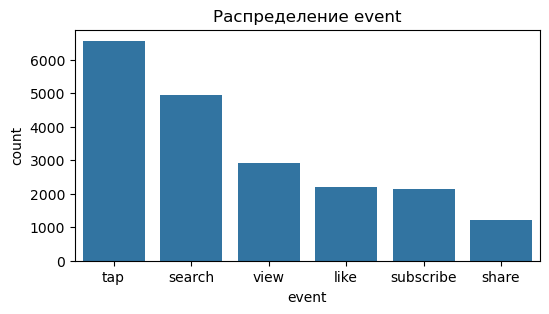

In [42]:
plt.figure(figsize=(6, 3))
sns.barplot(df['event'].value_counts())
plt.title('Распределение event')

In [43]:
# А так выглядит распределение event для view_time > 0
df[df['view_time'] > 0]['event'].value_counts()

event
view    2917
Name: count, dtype: int64

<Axes: xlabel='view_time', ylabel='Count'>

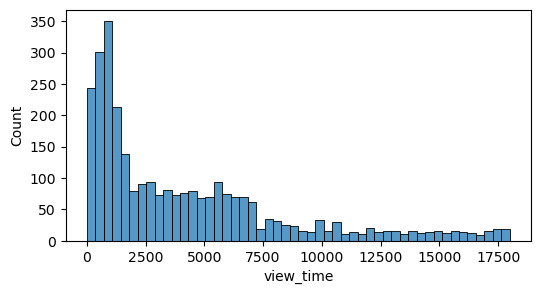

In [44]:
plt.figure(figsize=(6, 3))
sns.histplot(df[df['view_time'] > 0]['view_time'], bins=50)

In [45]:
# Очень мало вообще таких событий
df[(df['view_time'] > 0) & (df['view_time'] < 4)]

,user_id,sex,age,platform,query_id,query_text,query_type,event,click_position,doc_type,view_time,is_success,is_doc_ambiguous


<Axes: xlabel='view_time', ylabel='Count'>

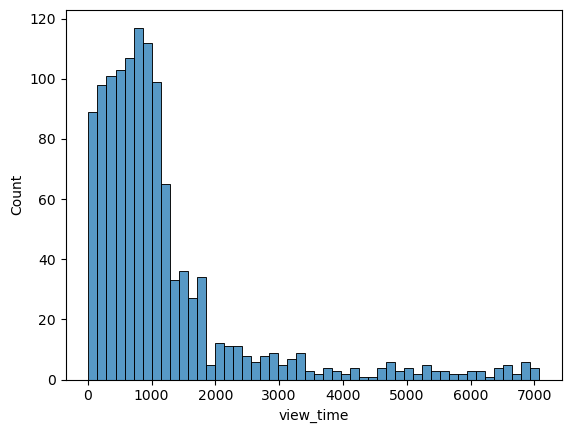

In [46]:
sns.histplot(df[(df['view_time'] > 0) & (df['doc_type'] == 'clip')]['view_time'], bins=50)

Я убрал из анализа распределения просмотры клипов с временем = 0, тк если человек даже на секунду не задержался на клипе, как я могу судить об его удержании на нем?  
Как понимать такое распределение времени просмотра для клипов? Максимальная длина клипа во «ВКонтакте» — от 3 секунд до 3 минут. (Возможно человек условно оставил экран телефона включенным, сам отошел, а клип все это время играл?)

**Не могу ни не отвергнуть, ни опровергнуть гипотезу "Низкое удержание при просмотре может свидетельствовать о нерелевантном результате поиска." - требуется более четкое понимание данных**

In [49]:
# попробуем переформулировать гипотезу

## Гипотеза: Высокий bounce rate после клика
Пользователь делает tap, но нет view → сигнал "ложнопозитивной" привлекательности результата.

In [51]:
tap_df = df[df['event'] == 'tap']

In [52]:
view_df = df[df['event'] == 'view']

In [53]:
merged = tap_df.merge(
    view_df[['user_id', 'query_id', 'view_time']],
    on=['user_id', 'query_id'],
    how='left'
)

In [54]:
bad_taps = merged[(merged['view_time_y'].isna())]

bad_tap_share = len(bad_taps) / len(tap_df)

print(f"Всего tap: {len(tap_df)}")
print(f"Плохих tap (без view или <3 сек): {len(bad_taps)}")
print(f"Доля таких: {bad_tap_share:.1%}")

Всего tap: 6564
Плохих tap (без view или <3 сек): 6481
Доля таких: 98.7%


Ну опять же странно, сделать тап, но нет даже просмотра. \
Конкретно на данном датасете нет смысла изучать поведенческие паттерны пользователя, так как желательно иметь для этого временную метку, что б понимать юзер делал запросы в примерно один период времени или в разные - так выводы будут корректнее.

## Гипотеза: CTR по категориям query_type отличается
Если CTR по категориям query_type значимо отличается, то по какой-то из категорий вовлеченность пользователя хуже.

In [114]:
df['query_type'].value_counts()

query_type
show     5000
news     5000
music    5000
films    5000
Name: count, dtype: int64

In [152]:
engaged_events = ['tap', 'view', 'like', 'subscribe', 'share']
df['is_engaged'] = df['event'].isin(engaged_events)

contingency = pd.crosstab(df['query_type'], df['is_engaged'])
print("Контингентная таблица (query_type × вовлеченность):")
print(contingency)

chi2, p, dof, expected = chi2_contingency(contingency)
print(f"\nХи-квадрат статистика = {chi2:.4f}")
print(f"p-value = {p:.5f}")

if p < 0.05:
    print("Различия между query_type статистически значимы (отклоняем H0)")
else:
    print("Нет статистически значимых различий (не отклоняем H0)")

Контингентная таблица (query_type × вовлеченность):
is_engaged  False  True 
query_type              
films        1258   3742
music        1227   3773
news         1232   3768
show         1241   3759

Хи-квадрат статистика = 0.5975
p-value = 0.89701
Нет статистически значимых различий (не отклоняем H0)


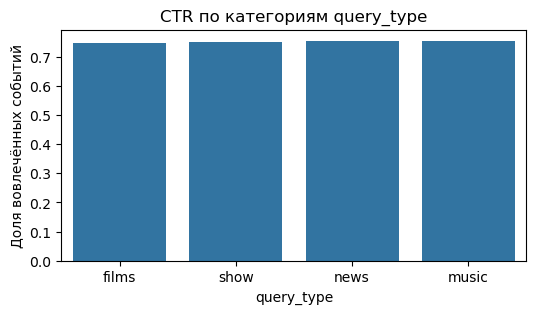


CTR по категориям:
query_type
films    0.7484
show     0.7518
news     0.7536
music    0.7546
Name: is_engaged, dtype: float64


In [156]:
ctr_by_query_type = df.groupby('query_type')['is_engaged'].mean().sort_values()

plt.figure(figsize=(6, 3))
sns.barplot(x=ctr_by_query_type.index, y=ctr_by_query_type.values)
plt.title("CTR по категориям query_type")
plt.ylabel("Доля вовлечённых событий")
plt.show()

print("\nCTR по категориям:")
print(ctr_by_query_type)

**Гипотеза не подтвердилась - по категориям query_type значимо не отличается**

## Summary

С высокой долей уверенности можно говорить о следующем:
1) В кейсах, где doc_type не определен, пользователи не совершают целевых действий (можно предлагать гибридную выдачу (например, видео + клипы).
2) Верх выдачи результата запроса чаще всего нерелевантен (скорее всего нужно улучшать рекомендательные системы).

При этом найдены следущие моменты, на которые стоит обратить внимание:
1) Большинство query не начинаются с search, вместо этого сразу наблюдается целевое действие (либо юзер сразу тапает на элемент с главного экрана, либо датасет подрезанный)
2) Есть такие кейсы где query_id одинаковый, но user_id разные
3) Странное распределения времени просмотров для клипов. (Возможно человек условно оставил экран телефона включенным, сам отошел, а клип все это время играл?)